In [1]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


from sklearn.linear_model import LinearRegression

In [2]:
df_train = pd.read_pickle("df_train.pkl")
df_validation = pd.read_pickle("df_validation.pkl")
df_test = pd.read_pickle("df_test.pkl")
df_price = pd.read_pickle("df_price.pkl")
df_option = pd.read_pickle("df_merged.pkl")

### **This notebook aims to perform exploratory analyses. It serves as a space for prototyping and experimentation. The code here is not meant for production use but is intended to inspire and guide me in designing strategies.**

----

----

## **FOUNDATION**

PRICER

In [3]:
def black_scholes_call_price(S, K, T, r, sigma):
    if T <= 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2)* T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def black_scholes_put_price(S, K, T, r, sigma):
    if T <= 0:
        return max(K - S, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

def black_scholes_call_delta(S, K, T, r, sigma):
    if T <= 0:
        return 1.0 if S > K else 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def black_scholes_put_delta(S, K, T, r, sigma):
    if T <= 0:
        return -1.0 if S < K else 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1) - 1 

Backtester function

In [4]:
    def get_rows_price_date(date1,date2):
        '''This function retrieves from the DataFrame the spot prices for the 
        dates between date1 and date2.
        
        RETURNS
        -------
        type : pandas.core.frame.DataFrame
        '''
        filtered = df_price[(df_price['Date'] >= date1) & (df_price['Date'] <= date2)]
        return filtered

In [5]:
def run_gamma_scalping(straddle_row):
    '''

    PARAMETERS
    ----------
    straddle_row : 
        pandas.core.series.Series
    '''
    res = {}

    PNL_evolution = [] # evolution of the pnl at each time step of the delta hedging
    hedge_gain = []

    Straddle_t0 = straddle_row['Straddle']

    df_prices_lifetime = get_rows_price_date(straddle_row['Date'],straddle_row[' [EXPIRE_DATE]']) # We retrieve the df of the spot prices associated to the lifetime of the straddle

    # avoid splited stock problem
    if straddle_row['Date'] <= " 2020-07-31":
        date_to_price = dict(zip(df_prices_lifetime['Date'], df_prices_lifetime['Price_unsplited'])) # We create the dictionnary of date and associated unsplited price
    elif straddle_row['Date'] >= " 2020-09-01":
        date_to_price = dict(zip(df_prices_lifetime['Date'], df_prices_lifetime['Price'])) # We create the dictionnary of date and associated price
    else:
        return {'PNL':0, 'price_strad':0, 'gross_gain':0} 


    list_date = list(date_to_price.keys())

    r = 0.03
    iv_call = straddle_row[' [C_IV]']
    iv_put = straddle_row[' [P_IV]']

    # Hedging part
    for i in range(1, len(date_to_price)):
        S_tbefore = date_to_price[list_date[i-1]]
        S_t = date_to_price[list_date[i]]

        time_to_maturity_before = (len(list_date) - (i - 1)) / 252
        time_to_maturity = (len(list_date) - i) / 252

        C_tbefore = black_scholes_call_price(S_tbefore, straddle_row[' [STRIKE]'], time_to_maturity_before, r, iv_call)
        C_t = black_scholes_call_price(S_t, straddle_row[' [STRIKE]'], time_to_maturity, r, iv_call)
        P_tbefore = black_scholes_put_price(S_tbefore, straddle_row[' [STRIKE]'], time_to_maturity_before, r, iv_put)
        P_t = black_scholes_put_price(S_t, straddle_row[' [STRIKE]'], time_to_maturity, r, iv_put)

        Straddle_before = C_tbefore + P_tbefore
        Straddle_t = C_t + P_t

        delta_call_t = black_scholes_call_delta(S_tbefore, straddle_row[' [STRIKE]'], time_to_maturity_before, r, iv_call)
        delta_put_t = black_scholes_put_delta(S_tbefore, straddle_row[' [STRIKE]'], time_to_maturity_before, r, iv_put)

        hedge_value = (-delta_call_t * (S_t - S_tbefore) +
                    (delta_call_t * S_tbefore - C_tbefore) * (np.exp(r * (1/252)) - 1)
                    - delta_put_t * (S_t - S_tbefore) +
                    (delta_put_t * S_tbefore - P_tbefore) * (np.exp(r * (1/252)) - 1))

        hedge_gain.append(hedge_value)

        pnl_total_t = (Straddle_t - Straddle_t0) + np.sum(hedge_gain[:i])
        PNL_evolution.append(pnl_total_t)
    
    res['PNL'] = PNL_evolution[-1]
    res['price_strad'] = Straddle_t0
    res['gross_gain'] = PNL_evolution[-1] + Straddle_t0

    return res

In [6]:
def run_backtest(df_backtest, strategy):
    PNL = 0
    Investment_capital = 0
    df_filtered = df_backtest[df_backtest['Date'] > " 2016-03-01"]
    for _, row in df_filtered.iterrows():
        trade_signal = "SKIP"
        if strategy.should_trade(row):
            signal = strategy.get_signal(row)
            res = run_gamma_scalping(row)
            if signal == 'LONG' :
                PNL += res['PNL']
                trade_signal = 'LONG'
            else : # If signal == 'SHORT'
                PNL += -res['PNL']
                trade_signal = 'SHORT'                
            Investment_capital += res['price_strad']
        #print(f"Date:{row['Date']}, PNL:{PNL}, Decision to trade:{trade_signal}")
    
    print(f"PNL:{PNL}, ROI:{(PNL/Investment_capital)*100} %")
    return res

In [7]:
df_train.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'j_quote',
       '[QUOTE_UNIXTIME]', ' [QUOTE_READTIME]', ' [QUOTE_DATE]',
       ' [QUOTE_TIME_HOURS]', ' [UNDERLYING_LAST]', ' [EXPIRE_DATE]',
       ' [EXPIRE_UNIX]', ' [DTE]', ' [C_DELTA]', ' [C_GAMMA]', ' [C_VEGA]',
       ' [C_THETA]', ' [C_RHO]', ' [C_IV]', ' [C_VOLUME]', ' [C_LAST]',
       ' [C_SIZE]', ' [C_BID]', ' [C_ASK]', ' [STRIKE]', ' [P_BID]',
       ' [P_ASK]', ' [P_SIZE]', ' [P_LAST]', ' [P_DELTA]', ' [P_GAMMA]',
       ' [P_VEGA]', ' [P_THETA]', ' [P_RHO]', ' [P_IV]', ' [P_VOLUME]',
       ' [STRIKE_DISTANCE]', ' [STRIKE_DISTANCE_PCT]', 'day_to_maturity',
       'moneyness', 'IV', 'vol_real', 'Straddle', 'call_delta', 'put_delta'],
      dtype='object')

-----

----

# 1. **Evolution of IV and RV for each straddle**

The following charts show the evolution of IV and RV for each straddle in df_train over time. For the same date, there can be multiple straddles because maturities may differ.

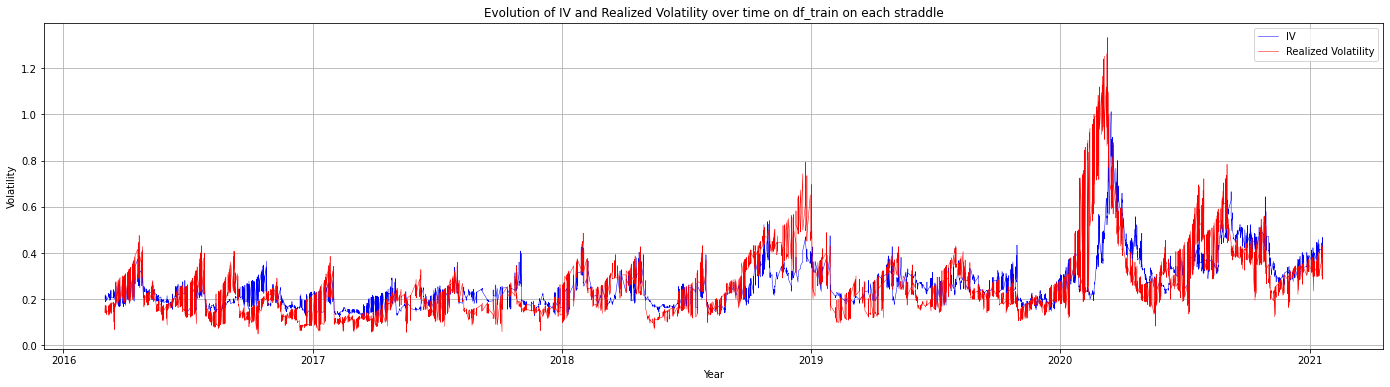

In [8]:
df_filtered = df_train[df_train['Date'] > " 2016-03-01"].copy()
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

plt.figure(figsize=(24, 6))
plt.plot(df_filtered['Date'], df_filtered['IV'], linewidth=0.5, color='blue', label='IV')
plt.plot(df_filtered['Date'], df_filtered['vol_real'], linewidth=0.5, color='red', label='Realized Volatility')
plt.xlabel('Year')
plt.ylabel('Volatility')
plt.title('Evolution of IV and Realized Volatility over time on df_train on each straddle')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()


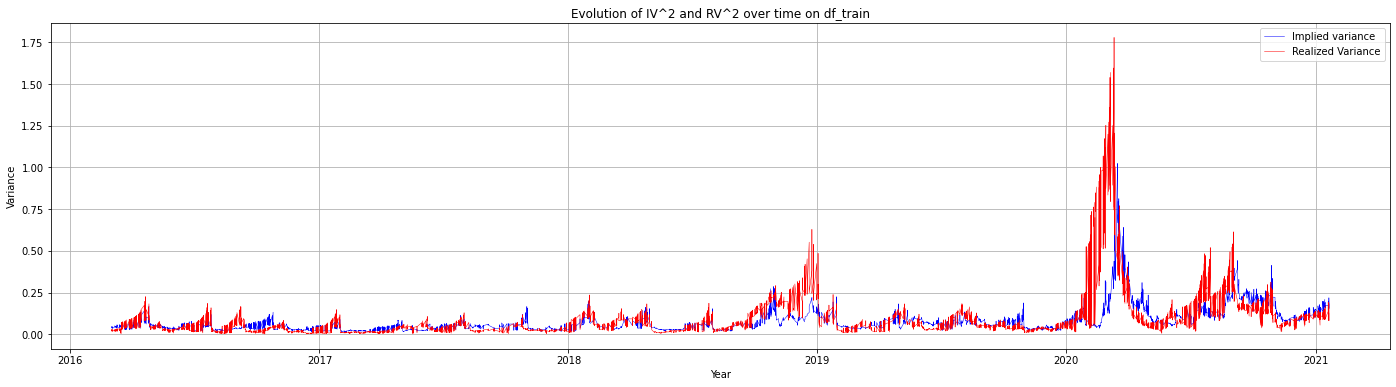

In [9]:
df_filtered = df_train[df_train['Date'] > " 2016-03-01"].copy()
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

plt.figure(figsize=(24, 6))
plt.plot(df_filtered['Date'], df_filtered['IV']**2, linewidth=0.5, color='blue', label='Implied variance')
plt.plot(df_filtered['Date'], df_filtered['vol_real']**2, linewidth=0.5, color='red', label='Realized Variance')
plt.xlabel('Year')
plt.ylabel('Variance')
plt.title('Evolution of IV^2 and RV^2 over time on df_train')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

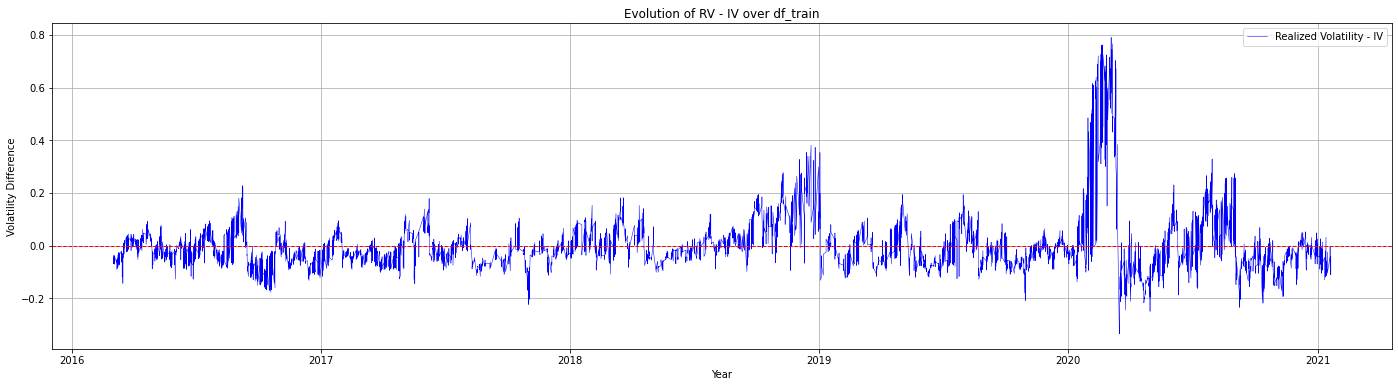

In [10]:
df_filtered = df_train[df_train['Date'] > " 2016-03-01"].copy()
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

plt.figure(figsize=(24, 6))
plt.plot(df_filtered['Date'], df_filtered['vol_real'] - df_filtered['IV'], linewidth=0.5, color='blue', label='Realized Volatility - IV')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Year')
plt.ylabel('Volatility Difference')
plt.title('Evolution of RV - IV over df_train')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()


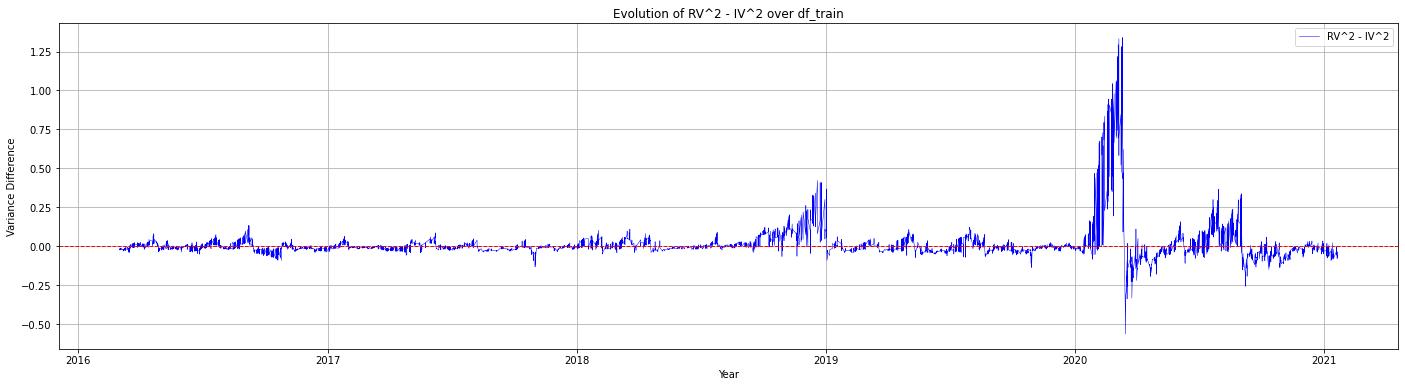

In [11]:
df_filtered = df_train[df_train['Date'] > " 2016-03-01"].copy()
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

plt.figure(figsize=(24, 6))
plt.plot(df_filtered['Date'], df_filtered['vol_real']**2 - df_filtered['IV']**2, linewidth=0.5, color='blue', label='RV^2 - IV^2')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Year')
plt.ylabel('Variance Difference')
plt.title('Evolution of RV^2 - IV^2 over df_train')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()


In [12]:
print(df_validation['Date'].head())
print(df_validation['Date'].dtype)

1028499     2021-01-21
1028569     2021-01-21
1028700     2021-01-21
1028758     2021-01-21
1028783     2021-01-21
Name: Date, dtype: object
object


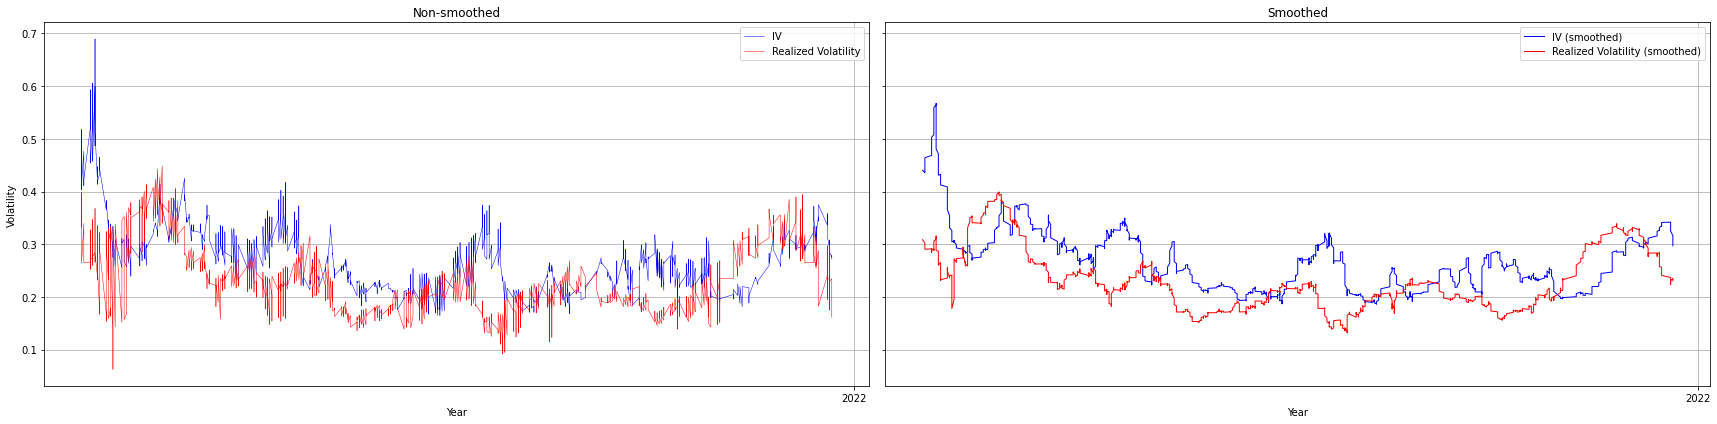

In [13]:
window = 10
df_validation['Date'] = pd.to_datetime(df_validation['Date'])
df_validation['IV_smooth'] = df_validation['IV'].rolling(window=window, center=True).mean()
df_validation['vol_real_smooth'] = df_validation['vol_real'].rolling(window=window, center=True).mean()

fig, axes = plt.subplots(1, 2, figsize=(24, 6), sharey=True)


axes[0].plot(df_validation['Date'], df_validation['IV'], linewidth=0.5, color='blue', label='IV')
axes[0].plot(df_validation['Date'], df_validation['vol_real'], linewidth=0.5, color='red', label='Realized Volatility')
axes[0].set_title('Non-smoothed')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Volatility')
axes[0].legend()
axes[0].grid(True)
axes[0].xaxis.set_major_locator(mdates.YearLocator())
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


axes[1].plot(df_validation['Date'], df_validation['IV_smooth'], linewidth=1, color='blue', label='IV (smoothed)')
axes[1].plot(df_validation['Date'], df_validation['vol_real_smooth'], linewidth=1, color='red', label='Realized Volatility (smoothed)')
axes[1].set_title('Smoothed')
axes[1].set_xlabel('Year')
axes[1].legend()
axes[1].grid(True)
axes[1].xaxis.set_major_locator(mdates.YearLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

df_validation['Date'] = df_validation['Date'].dt.strftime(' %Y-%m-%d')

# **TERM STRUCTURE study**
The following charts show, for 50 randomly selected dates from df_train, the IV and RV of straddles as a function of days to maturity.

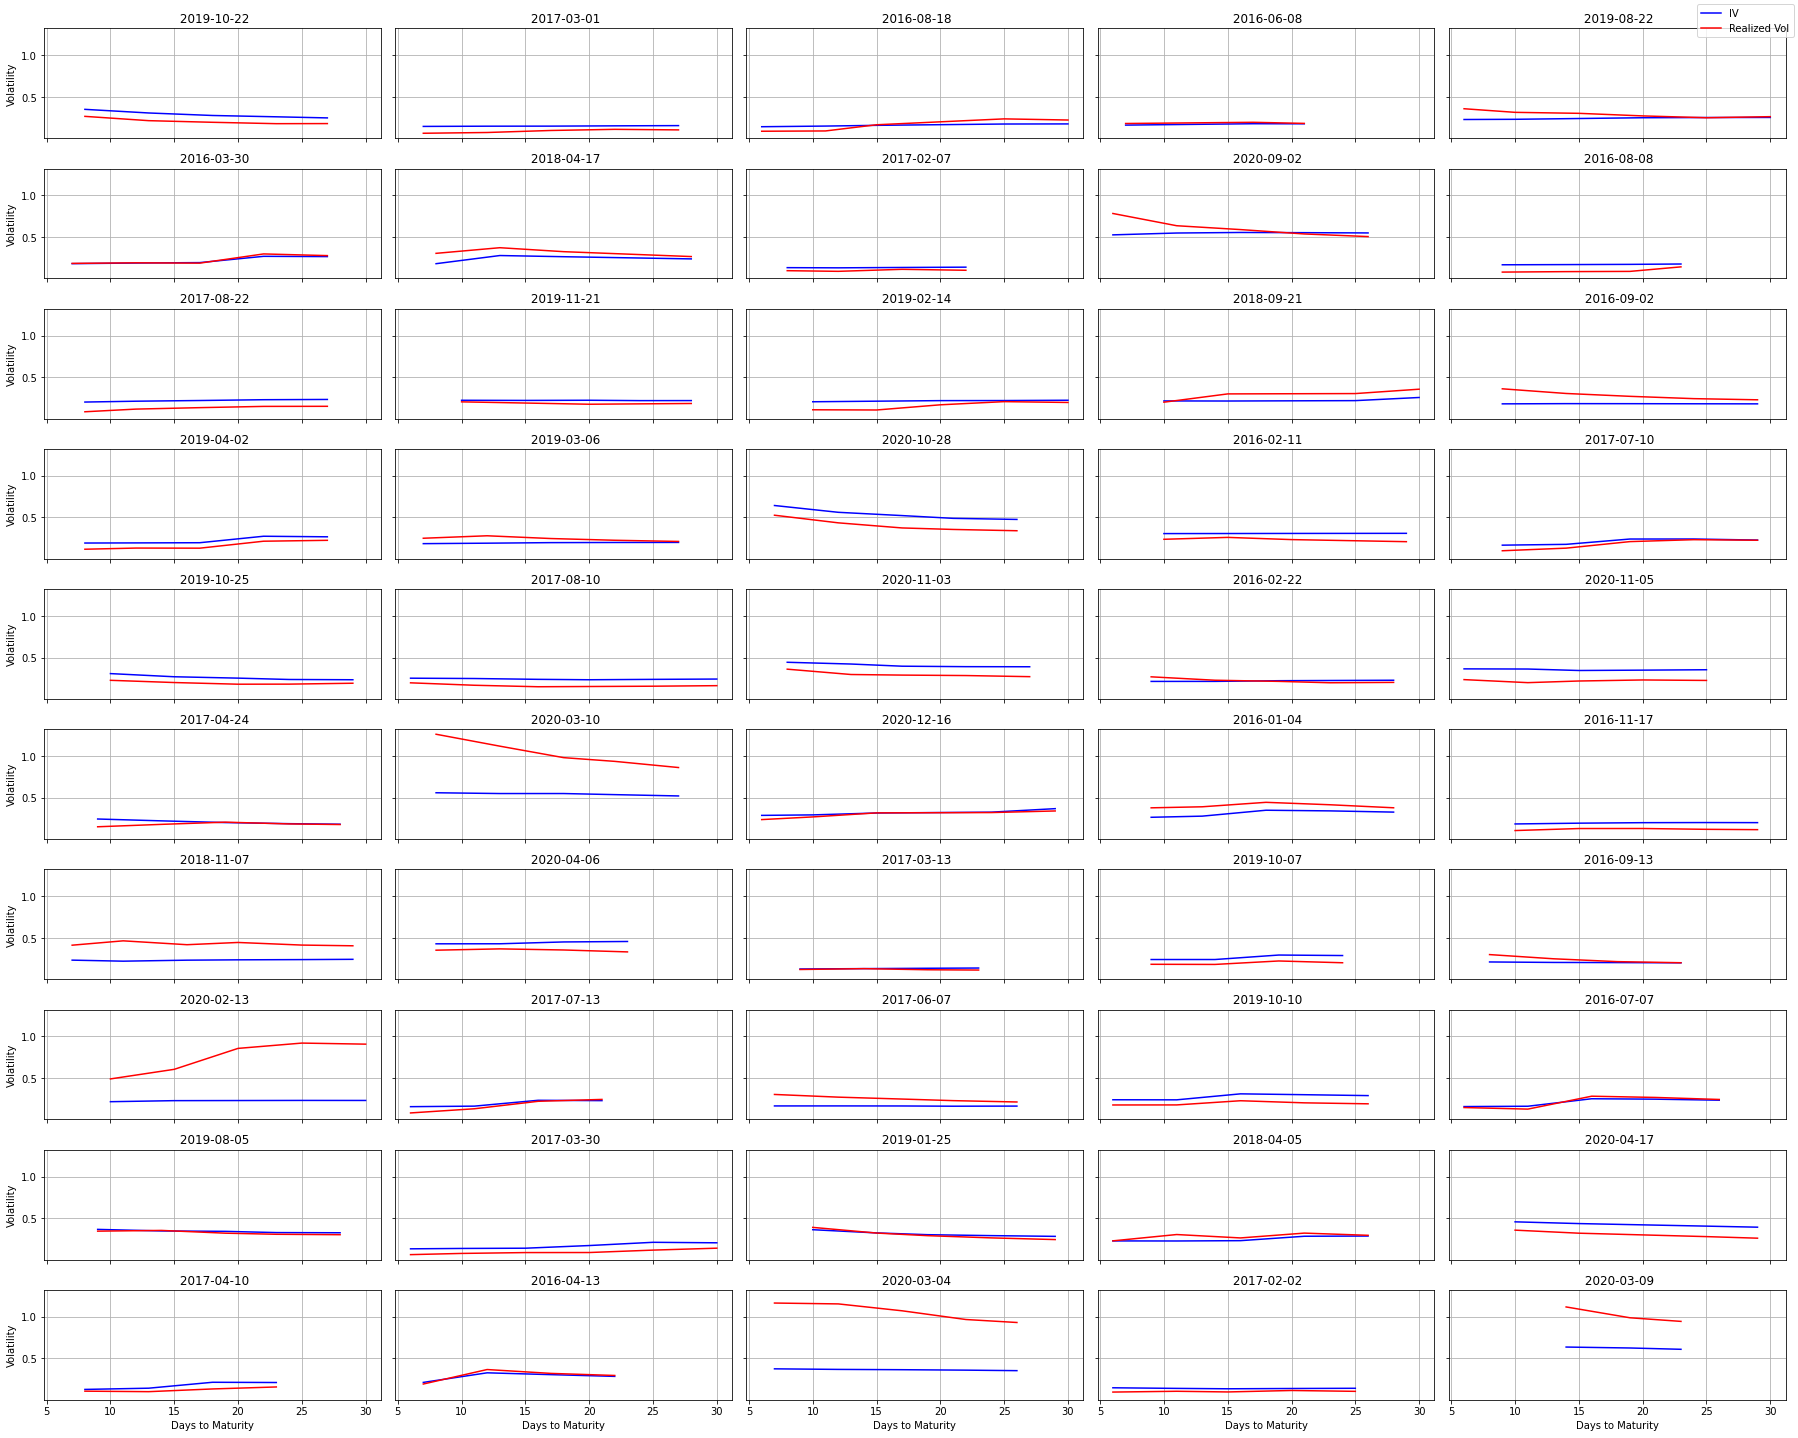

In [14]:
df_mean = df_train.groupby(["Date", "day_to_maturity"])[["IV", "vol_real"]].mean().reset_index()
dates_sample = np.random.choice(df_mean['Date'].unique(), size=50, replace=False)

n_rows = 10
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 20), sharex=True, sharey=True)
axes = axes.flatten()

for i, date in enumerate(dates_sample):
    subset = df_mean[df_mean['Date'] == date]
    axes[i].plot(subset['day_to_maturity'], subset['IV'], color='blue', label='IV')
    axes[i].plot(subset['day_to_maturity'], subset['vol_real'], color='red', label='Realized Vol')
    axes[i].set_title(str(date))
    axes[i].grid(True)
    if i % n_cols == 0:
        axes[i].set_ylabel("Volatility")
    if i >= (n_rows-1)*n_cols:
        axes[i].set_xlabel("Days to Maturity")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

---

----

# 2. **GARCH and notion of volatility**

Let's say $X_t$ the log-return process with $\mathbb{E}[X_t] = 0$ and $\mathbb{V}[X_t] = \sigma^2$. By definition, the volatility is $\sigma$.

Given a statistical series ($X_1, X_2, \dots, X_n$) the empirical estimator for the $volatility^2$ is :

$ \hat{\sigma}^2 = \frac{1}{n} \sum_{t=1}^{n} \big(X_t - \bar{X})^2 $ with $\bar{X} \approx 0$



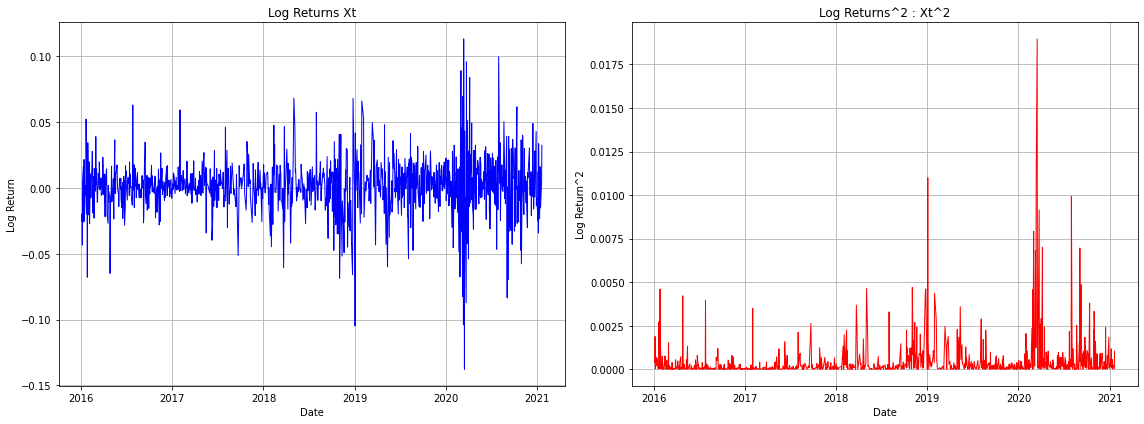

In [15]:
# log returns of df_train
mask = df_price['Date'].isin(df_train['Date'])
df_filtered = df_price[mask]
log_returns = np.log(df_filtered['Price']).diff()
log_returns_squared = log_returns**2

fig, axes = plt.subplots(1, 2, figsize=(16,6), sharex=True)
axes[0].plot(pd.to_datetime(df_filtered['Date']), log_returns, color='blue', linewidth=1)
axes[0].set_title('Log Returns Xt')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Log Return')
axes[0].grid(True)

axes[1].plot(pd.to_datetime(df_filtered['Date']), log_returns_squared, color='red', linewidth=1)
axes[1].set_title('Log Returns^2 : Xt^2')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Log Return^2')
axes[1].grid(True)

plt.tight_layout()
plt.show()

To give us an idea of the volatility of the log-return, we study the plot of the squared series. Indeed,
squaring the series effectively captures its variance.
We observe that periods of high volatility are followed by periods of low volatility.


INTERPRETATION : One can suspect conditional heteroskedasticity in the series, in other words,
the conditional variance is not constant over time. Thus, the most relevant model to fit appears to be a **GARCH** model (Generalized autoregressive conditional heteroscedastic).

The GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model can be written as:

$$
X_t = \sigma_t \epsilon_t
$$

$$
\sigma_t^2 = \omega + \alpha_1 X_{t-1}^2 + \dots + \alpha_p X_{t-p}^2 + \beta_1 \sigma_{t-1}^2 + \dots + \beta_q \sigma_{t-q}^2
$$

where:

- $X_t$ is the log-return process at time $t$  
- $\sigma_t^2$ is the conditional variance at time $t$  
- $\omega$ is the constant term  
- $\alpha_i$ are the ARCH coefficients (effects of past squared values)  
- $\beta_j$ are the GARCH coefficients (effects of past conditional variances)  
- $\epsilon_t$ is a standard Gaussian white noise at time $t$


Under GARCH assumption, $\mathbb{V}[X_t|\mathcal{F}_{t-1}] = \sigma^2_t$

In other words, $\sigma^2_t$ is the instantaneous variance of $X_t$ **at time t** given the past. 

So, to compute the annualized volatility over a given period, we should calculate the arithmetic average of the daily volatilities $\sigma_t \ \forall t \in\ period$ during that period given by **GARCH**, then multiply it by the square root of 252.

**EXAMPLE** :
For a period = week of 5 trading days :

$$volatility = \frac{1}{5}\sum_{t=1}^{5} \sigma_t $$
$$\sigma_{annualized} = volatility * \sqrt{252}$$



**PROOF** : 

considering the following filtration : $\mathcal{F}_t = \sigma((X_s)_{s\le t})$ we have :
$$\mathbb{V}[X_t|\mathcal{F}_{t-1}] = \mathbb{E}[(X_t - \mathbb{E}[X_t|\mathcal{F}_{t-1}])^2|\mathcal{F}_{t-1}] = \mathbb{E}[X^2_{t}|\mathcal{F}_{t-1}] - \mathbb{E}[X_t|\mathcal{F}_{t-1}]^2 = \mathbb{E}[X^2_{t}|\mathcal{F}_{t-1}]$$

With $\mathbb{E}[X_t|\mathcal{F}_{t-1}] = \mathbb{E}[\sigma_t \epsilon_t | \mathcal{F}_{t-1}] = \mathbb{E}[\epsilon_t]\mathbb{E}[\sigma_t|\mathcal{F}_{t-1}] = 0$
Beacause, $\sigma_t$ and $\epsilon_t$ are independent. 


Then we have : 
$$\mathbb{E}[X^2_{t}|\mathcal{F}_{t-1}] = \mathbb{E}[\sigma^2_t\ \epsilon^2_t | \mathcal{F}_{t-1}] = \sigma^2_t \mathbb{E}[\epsilon^2_t|\mathcal{F}_{t-1}] =  \sigma^2_t\ \mathbb{E}[\epsilon^2_t] = \sigma^2_t$$
Because $\sigma^2_t$ is mesurable for the $\mathcal{F}_{t-1}$ $\sigma$-algebra and $\epsilon_t$ is independant of the $\mathcal{F}_{t-1}$ $\sigma$-algebra.

In [16]:
from arch import arch_model

We retrieve the spot prices available for date in df_train.

In [17]:
df_filtered = df_price[df_price['Date'].isin(df_train['Date'].unique())].copy()

Let's fit the GARCH model on df_train historical data price.

**Warning** : It is better to multiply returns by 100 and express them in percentages to make it easier for the optimization algorithms to estimate the GARCH parameters.

In [18]:
log_returns = np.log(df_filtered['Price'] / df_filtered['Price'].shift(1)).dropna() * 100  # in %

In [19]:
# Find the best GARCH(p,q) model using AIC
best_aic = np.inf
best_order = None
results = {}

for p in range(0, 4):
    for q in range(0, 4):
        try:
            model = arch_model(log_returns, vol='Garch', p=p, q=q)
            res = model.fit(disp='off')
            results[(p, q)] = res.aic
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = (p, q)
        except:
            continue

print("Best order (p,q):", best_order, "with AIC =", best_aic)

# Optional: print AIC for all tested (p,q)
print("AIC for each (p,q) tried:")
for k, v in results.items():
    print(f"p={k[0]}, q={k[1]} -> AIC={v:.2f}")

Best order (p,q): (2, 1) with AIC = 4392.734346849402
AIC for each (p,q) tried:
p=1, q=0 -> AIC=4603.33
p=1, q=1 -> AIC=4395.60
p=1, q=2 -> AIC=4397.60
p=1, q=3 -> AIC=4399.60
p=2, q=0 -> AIC=4520.04
p=2, q=1 -> AIC=4392.73
p=2, q=2 -> AIC=4394.28
p=2, q=3 -> AIC=4396.28
p=3, q=0 -> AIC=4436.78
p=3, q=1 -> AIC=4393.87
p=3, q=2 -> AIC=4395.87
p=3, q=3 -> AIC=4397.26


In [20]:
best_model = arch_model(log_returns, vol='Garch', p=2, q=1) # We instantiate the GARCH class.

best_res = best_model.fit(disp='off')
print(best_res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2191.37
Distribution:                  Normal   AIC:                           4392.73
Method:            Maximum Likelihood   BIC:                           4417.76
                                        No. Observations:                 1102
Date:                Tue, Aug 26 2025   Df Residuals:                     1101
Time:                        16:40:56   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2680  5.296e-02      5.061  4.173e-07 [  0.164,  0.37

From the P-VALUE column, we can see that all the coefficients are significant at more than 99% instead of alpha[2] with a p-value of 0.168 which is no significant So we will retain the GARCH(1,1).

**REMARK** : α+β<1 the model is stationnary and converge toward a unconditional variance

The GARCH(1,1) model is defined as:

$$
X_t = \sigma_t \epsilon_t
$$

$$
\sigma_t^2 = \omega + \alpha_1 X_{t-1}^2 + \beta_1 \sigma_{t-1}^2
$$

where:

- $X_t$ is the process at time $t$  
- $\sigma_t^2$ is the conditional variance at time $t$  
- $\omega$ is the constant term  
- $\alpha_1$ is the ARCH(1) coefficient (effect of past squared value)  
- $\beta_1$ is the GARCH(1) coefficient (effect of past variance)  
- $\epsilon_t$ is a standard Gaussian white noise at time $t$


### **Let's fit the GARCH(1,1) model**

In [21]:
best_model = arch_model(log_returns, vol='Garch', p=1, q=1) # We instantiate the GARCH class.
best_res = best_model.fit(disp='off')

- ***best_res.conditional_volatility*** calculates the 1-day ahead predicted conditional volatility using past realized log returns using the GARCH model fited on the entire df_train spot price.

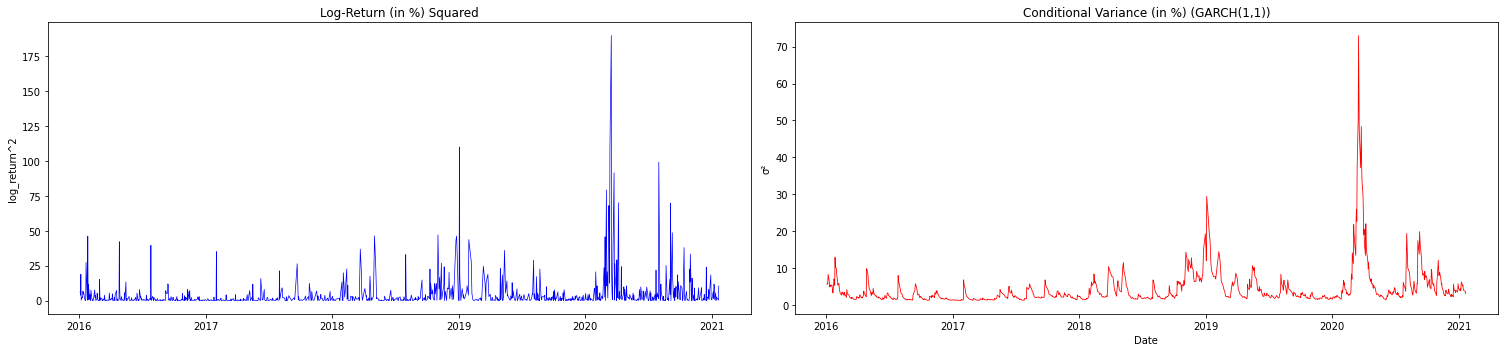

In [22]:
# log_return^2
log_return2 = log_returns**2
log_return2 = pd.Series(log_return2.values, index=pd.to_datetime(df_filtered['Date'].iloc[-len(log_return2):]))

# Conditional variance from GARCH
cond_var = (best_res.conditional_volatility)**2
cond_var = pd.Series(cond_var.values, index=pd.to_datetime(df_filtered['Date'].iloc[-len(cond_var):]))

fig, axs = plt.subplots(1, 2, figsize=(21,5), sharex=True)

axs[0].plot(log_return2, color='blue', linewidth=0.7)
axs[0].set_title("Log-Return (in %) Squared")
axs[0].set_ylabel("log_return^2")
axs[1].plot(cond_var, color='red', linewidth=0.8)
axs[1].set_title("Conditional Variance (in %) (GARCH(1,1))")
axs[1].set_ylabel("σ²")

plt.xlabel("Date")
plt.tight_layout()
plt.show()

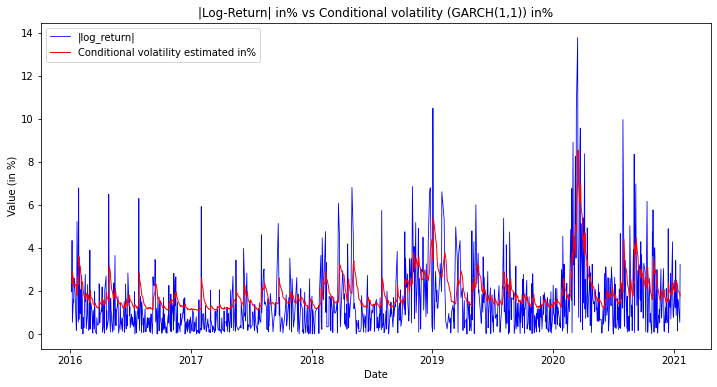

In [23]:
cond_var_aligned = cond_var.reindex(log_return2.index)

plt.figure(figsize=(12,6))
plt.plot(np.sqrt(log_return2), label='|log_return|', color='blue', linewidth=0.8)
plt.plot(np.sqrt(cond_var_aligned), label='Conditional volatility estimated in%', color='red', linewidth=1)
plt.title("|Log-Return| in% vs Conditional volatility (GARCH(1,1)) in%")
plt.xlabel("Date")
plt.ylabel("Value (in %)")
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


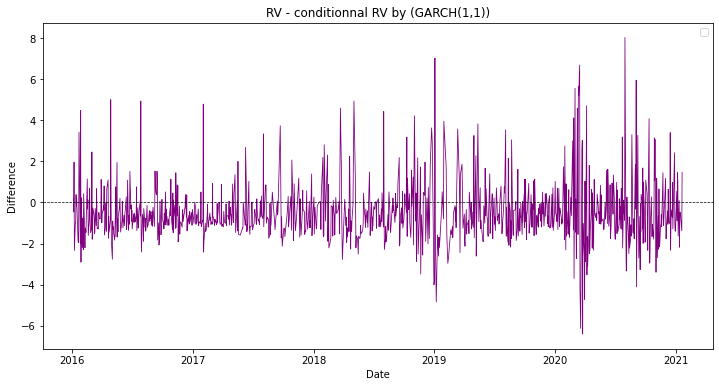

In [24]:
# Différence
diff =  np.sqrt(log_return2) - np.sqrt(cond_var_aligned)

# Plot
plt.figure(figsize=(12,6))
plt.plot(diff, color='purple', linewidth=0.8)
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
plt.title("RV - conditionnal RV by (GARCH(1,1))")
plt.xlabel("Date")
plt.ylabel("Difference")
plt.legend()
plt.show()

diff is the difference between the real instant volatility and the conditionnal volatility estimated by GARCH(1,1)

In [25]:
diff.describe()

count    1102.000000
mean       -0.523282
std         1.414062
min        -6.400484
25%        -1.256799
50%        -0.787671
75%        -0.018587
max         8.030031
dtype: float64

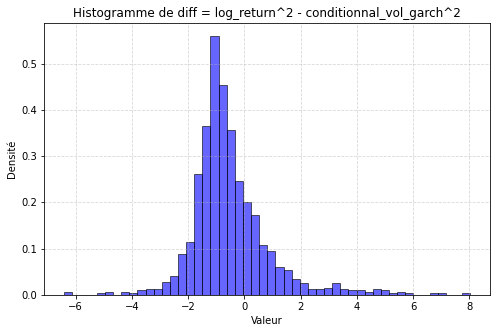

In [26]:
plt.figure(figsize=(8,5))
plt.hist(diff.dropna(), bins=50, density=True, alpha=0.6, color='blue', edgecolor='black')
plt.title("Histogramme de diff = log_return^2 - conditionnal_vol_garch^2")
plt.xlabel("Valeur")
plt.ylabel("Densité")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [27]:
forecast = best_res.forecast(horizon=30)
forecast.variance[-1:]

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.21,h.22,h.23,h.24,h.25,h.26,h.27,h.28,h.29,h.30
1270,4.170689,4.184721,4.19799,4.210537,4.222403,4.233623,4.244234,4.254268,4.263756,4.272728,...,4.344412,4.349,4.353339,4.357442,4.361321,4.36499,4.368459,4.37174,4.374843,4.377776


In [28]:
forecast.variance

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.21,h.22,h.23,h.24,h.25,h.26,h.27,h.28,h.29,h.30
1270,4.170689,4.184721,4.19799,4.210537,4.222403,4.233623,4.244234,4.254268,4.263756,4.272728,...,4.344412,4.349,4.353339,4.357442,4.361321,4.36499,4.368459,4.37174,4.374843,4.377776


In [29]:
forecast.variance.values[-1]

array([4.17068914, 4.18472083, 4.19798974, 4.21053735, 4.22240286,
       4.23362335, 4.24423389, 4.25426763, 4.26375593, 4.27272843,
       4.28121319, 4.28923671, 4.29682406, 4.30399896, 4.31078383,
       4.31719986, 4.32326712, 4.32900456, 4.3344301 , 4.33956071,
       4.34441241, 4.34900037, 4.35333893, 4.35744164, 4.36132132,
       4.3649901 , 4.36845945, 4.37174019, 4.3748426 , 4.37777635])

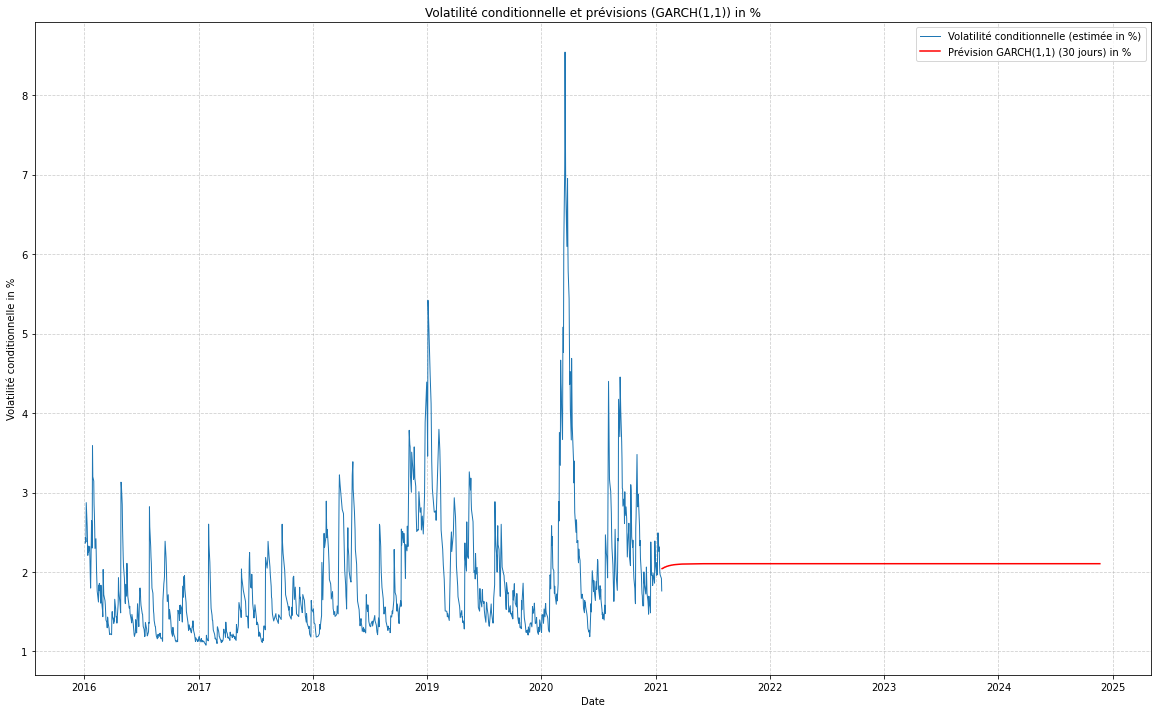

In [30]:
h=1000

# Volatilité conditionnelle estimée
cond_vol = best_res.conditional_volatility # in %'
cond_vol = pd.Series(cond_vol.values, index=pd.to_datetime(df_filtered['Date'].iloc[-len(cond_vol):]))

# Prévisions à horizon 30
forecast = best_res.forecast(horizon=h)
vol_forecast = forecast.variance.values[-1]  # tableau de taille (30,)
vol_forecast = np.sqrt(vol_forecast)
vol_forecast = pd.Series(vol_forecast, 
                         index=pd.date_range(start=cond_vol.index[-1] + pd.Timedelta(days=1), periods=h, freq="B"))

# Tracé
plt.figure(figsize=(20,12))
plt.plot(cond_vol, label="Volatilité conditionnelle (estimée in %)", linewidth=1)
plt.plot(vol_forecast, label="Prévision GARCH(1,1) (30 jours) in %", color="red")
plt.title("Volatilité conditionnelle et prévisions (GARCH(1,1)) in %")
plt.xlabel("Date")
plt.ylabel("Volatilité conditionnelle in %")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

We can observe that the predicted conditional volatility converges very quickly to its stationary value. Therefore, for predictions, we will only consider the stationary volatility.

In [31]:
df_ess = df_validation[['Date','IV', 'vol_real']]

vol_garch = []

for date in df_validation['Date'].unique().tolist():
    id_date = df_price['Date'].tolist().index(date)
    df_filtered_price = df_price[:id_date]
    #df_filtered_stradd = df_validation[df_validation['Date'] == date] 
    log_returns = np.log(df_filtered_price['Price'] / df_filtered_price['Price'].shift(1)).dropna() * 100  # in %

    model = arch_model(log_returns, vol='Garch', p=1, q=1) # We instantiate the GARCH class.
    res = model.fit(disp='off')
    forecast = res.forecast(horizon=30)
    vol_forecast_garch = np.mean( np.sqrt(forecast.variance.values[-1]) /100) * np.sqrt(252)
    vol_garch.append(vol_forecast_garch)

df_garch = pd.DataFrame({'Date': df_validation['Date'].unique().tolist(), 'vol_garch': vol_garch})

In [32]:
df_merged_ess = df_ess.merge(df_garch, on='Date', how='left')

We compare the predicted volatility with realized volatility and implied volatility (IV) to assess the performance of our predictions.

**1. First filter :**  We simply check whether the predicted volatility is higher or lower than the IV independently of the term structure

In [33]:
condition = (
    ((df_merged_ess['vol_garch'] > df_merged_ess['IV']) & (df_merged_ess['vol_real'] > df_merged_ess['IV']))
    |
    ((df_merged_ess['vol_garch'] < df_merged_ess['IV']) & (df_merged_ess['vol_real'] < df_merged_ess['IV']))
)

percent = condition.mean() * 100
print(f"{percent:.2f}% were correctly predicted in terms of IV vs RV among {len(condition)} straddles traded")

48.18% were correctly predicted in terms of IV vs RV among 1345 straddles traded


**2. Second filter :** We keep only the dates where the predicted volatility is higher or lower than all implied volatilities (IV), across all maturities.

In [34]:
deal = []
for _,row in df_garch.iterrows():
    df_filtered_stradd = df_validation[df_validation['Date'] == row['Date']]
    if all(row['vol_garch'] > df_filtered_stradd['IV']) or all(row['vol_garch'] < df_filtered_stradd['IV']):
        deal.append(True)
    else :
        deal.append(False)
df_garch['deal'] = deal


In [35]:
df_merged_ess = df_ess.merge(df_garch, on='Date', how='left')

In [36]:
df_merged_ess = df_merged_ess[df_merged_ess['deal']]
condition = (
    ((df_merged_ess['vol_garch'] > df_merged_ess['IV']) & (df_merged_ess['vol_real'] > df_merged_ess['IV']))
    |
    ((df_merged_ess['vol_garch'] < df_merged_ess['IV']) & (df_merged_ess['vol_real'] < df_merged_ess['IV']))
)

# Pourcentage de lignes vérifiant la condition
percent = condition.mean() * 100

print(f"{percent:.2f}% were correctly predicted in terms of IV vs RV among {len(condition)} straddles traded")


46.02% were correctly predicted in terms of IV vs RV among 854 straddles traded


**3. Third filter :** Applying the two previous filters, we now keep only the straddles for which:

- if the predicted volatility is higher than all IVs, the straddle’s IV must be higher than the **average IV** across the term structure

- if the predicted volatility is lower than all IVs, the straddle’s IV must be lower than the **average IV** across the term structure

In [37]:
df_ess = df_validation[['Date','IV', 'vol_real']].copy()

deal = []
deal2 = []
for _,row in df_garch.iterrows():
    df_filtered_stradd = df_validation[df_validation['Date'] == row['Date']]
    if all(row['vol_garch'] > df_filtered_stradd['IV']) or all(row['vol_garch'] < df_filtered_stradd['IV']):
        deal += [True] * len(df_filtered_stradd)
        if all(row['vol_garch'] > df_filtered_stradd['IV']):
            deal2 += [True if row['IV'] > np.mean(df_filtered_stradd['IV']) else False for _, row in df_filtered_stradd.iterrows()]
        elif all(row['vol_garch'] < df_filtered_stradd['IV']):
            deal2 += [True if row['IV'] < np.mean(df_filtered_stradd['IV']) else False for _, row in df_filtered_stradd.iterrows()]
    else :
        deal += [False] * len(df_filtered_stradd)
        deal2 += [False] * len(df_filtered_stradd)



df_ess['deal'] = deal
df_ess['deal2'] = deal2


In [38]:
df_merged_ess = df_ess.merge(df_garch, on='Date', how='left')

In [39]:
df_merged_ess = df_merged_ess[df_merged_ess['deal2']]
condition = (
    ((df_merged_ess['vol_garch'] > df_merged_ess['IV']) & (df_merged_ess['vol_real'] > df_merged_ess['IV']))
    |
    ((df_merged_ess['vol_garch'] < df_merged_ess['IV']) & (df_merged_ess['vol_real'] < df_merged_ess['IV']))
)

# Pourcentage de lignes vérifiant la condition
percent = condition.mean() * 100

print(f"{percent:.2f}% were correctly predicted in terms of IV vs RV among {len(condition)} straddles traded")


45.31% were correctly predicted in terms of IV vs RV among 437 straddles traded


**3. Third filter :** Applying the 3 previous filters, we now keep only the straddles for which:

- if the predicted volatility is higher than all IVs, the straddle’s IV must be higher than the **75% percentile IV** across the term structure

- if the predicted volatility is lower than all IVs, the straddle’s IV must be lower than the **25% percentile IV** across the term structure

In [40]:
df_ess = df_validation[['Date','IV', 'vol_real']].copy()

deal = []
deal2 = []
for _,row in df_garch.iterrows():
    df_filtered_stradd = df_validation[df_validation['Date'] == row['Date']]
    if all(row['vol_garch'] > df_filtered_stradd['IV']) or all(row['vol_garch'] < df_filtered_stradd['IV']):
        deal += [True] * len(df_filtered_stradd)
        if all(row['vol_garch'] > df_filtered_stradd['IV']):
            deal2 += [True if row['IV'] > np.percentile(df_filtered_stradd['IV'], 75) else False for _, row in df_filtered_stradd.iterrows()]
        elif all(row['vol_garch'] < df_filtered_stradd['IV']):
            deal2 += [True if row['IV'] < np.percentile(df_filtered_stradd['IV'], 25) else False for _, row in df_filtered_stradd.iterrows()]
    else :
        deal += [False] * len(df_filtered_stradd)
        deal2 += [False] * len(df_filtered_stradd)



df_ess['deal'] = deal
df_ess['deal2'] = deal2


In [41]:
df_merged_ess = df_ess.merge(df_garch, on='Date', how='left')

In [ ]:

list_date = df_merged_ess['Date'].unique().tolist()
for d in list_date:
    print(df_merged_ess[df_merged_ess['Date'] == d])

In [43]:
df_merged_ess = df_merged_ess[df_merged_ess['deal2']]
condition = (
    ((df_merged_ess['vol_garch'] > df_merged_ess['IV']) & (df_merged_ess['vol_real'] > df_merged_ess['IV']))
    |
    ((df_merged_ess['vol_garch'] < df_merged_ess['IV']) & (df_merged_ess['vol_real'] < df_merged_ess['IV']))
)

percent = condition.mean() * 100

print(f"{percent:.2f}% were correctly predicted in terms of IV vs RV {len(condition)} straddles traded")


41.43% were correctly predicted in terms of IV vs RV 210 straddles traded


**Result**: The performance of our prediction strategies appears to decrease significantly as the filters are applied. It might therefore be more appropriate to adopt a strategy based on the opposite reasoning.

----

----

# **3. Regime Switching strategy : statistical strat (model free) and Markov regime switching (HMM)** 

We will revisit the results obtained from the graphs in Part **1. Evolution of IV and RV for each straddle** in this notebook.

In this exploratory study, we will examine volatility regime changes. The idea is to exploit sudden regime shifts to build a signal that identifies whether an option is underpriced or overpriced, based on its phase shift relative to the realized volatility. 

We can observe in the graphs from Part **1. Evolution of IV and RV for each straddle** that there is a temporal phase shift in sudden regime changes between IV and RV. This is confirmed by the following preliminary statistical analyses, showing the volatility histogram and the volatility clustering for two regimes.

In [89]:
from sklearn.mixture import GaussianMixture

Average of volatility per cluster : [0.0662334  0.23266717]


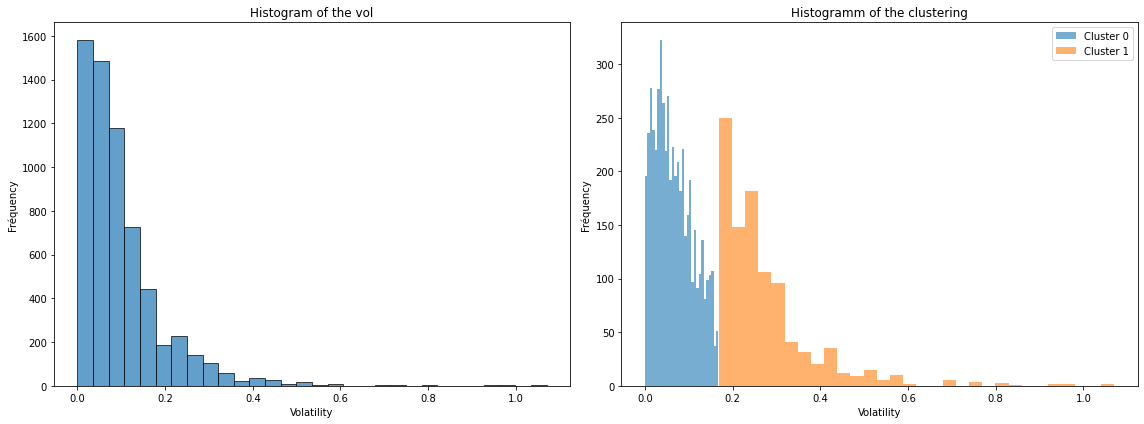

In [90]:
log_returns = np.log(df_train['Price'] / df_train['Price'].shift(1)).dropna()
rolling_window = 10
vol_10d = log_returns.rolling(rolling_window).std() * np.sqrt(252)
vol_10d_clean = vol_10d.dropna()
vol_10d_reshape = vol_10d_clean.values.reshape(-1, 1) 

# Volatility clustering
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(vol_10d_reshape)
labels = gmm.predict(vol_10d_reshape)
means = gmm.means_.flatten()
print(f"Average of volatility per cluster : {means}")

fig, axes = plt.subplots(1, 2, figsize=(16,6))

# Histogram
axes[0].hist(vol_10d_clean, bins=30, edgecolor='k', alpha=0.7)
axes[0].set_title('Histogram of the vol')
axes[0].set_xlabel('Volatility')
axes[0].set_ylabel('Fréquency')

# Clustering
axes[1].hist(vol_10d_reshape[labels==0], bins=30, alpha=0.6, label='Cluster 0')
axes[1].hist(vol_10d_reshape[labels==1], bins=30, alpha=0.6, label='Cluster 1')
axes[1].set_title('Histogramm of the clustering')
axes[1].set_xlabel('Volatility')
axes[1].set_ylabel('Fréquency')
axes[1].legend()

plt.tight_layout()
plt.show()

The main idea is that an asset’s volatility (whether realized volatility, RV, or implied volatility, IV) does not evolve uniformly. It alternates between different “states” or “regimes” (e.g., High Vol / Low Vol), each with its own statistical characteristics.

Strategy idea: exploit these moments of sudden phase shifts to create a signal:

- If RV suddenly rises but IV lags → the options market underestimates the volatility regime: buying opportunity.

- If IV suddenly rises sharply but RV remains low → straddles are overpriced: short volatility opportunity.

**Challenge** : is to identify and capture these sudden volatility changes.

### **1. First method** : Simple statistical methods without models : regime identification using thresholds.

In [91]:
df_filtered = df_train[['Date','Price']].drop_duplicates().copy()
df_filtered = df_filtered[df_filtered['Date'] > " 2016-03-01"]

In [92]:
rolling_window = 3
rv_lookahead = []
rv = []
iv = []

for _,row in df_filtered.iterrows():
    id_date = df_price['Date'].tolist().index(row['Date'])
    list_pric = df_price['Price'].iloc[id_date-rolling_window:id_date+1]

    iv.append(np.mean(df_train[df_train['Date'] == row['Date']]['IV']))
    rv.append(np.mean(df_train[df_train['Date'] == row['Date']]['vol_real']))
    
    logr = np.diff(np.log(list_pric))
    vol = np.sqrt(np.mean(logr ** 2) * 252)
    rv_lookahead.append(vol)




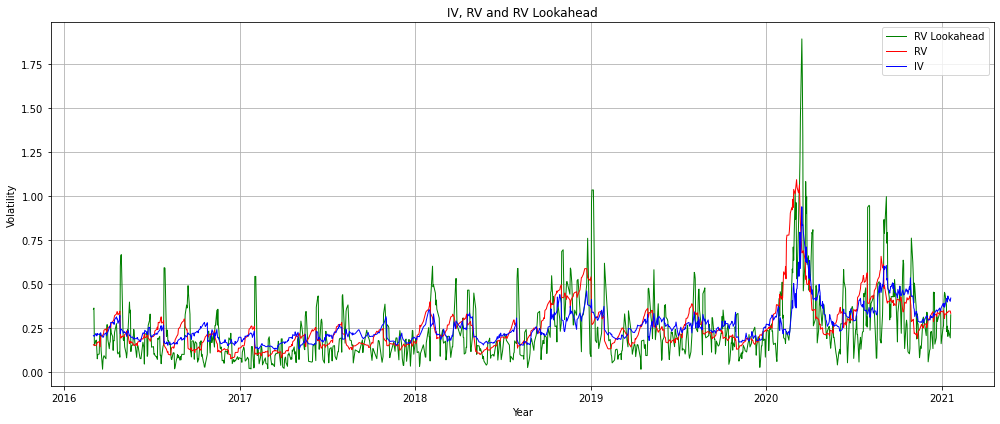

In [93]:
dates = pd.to_datetime(df_filtered['Date'])

plt.figure(figsize=(14,6))

plt.plot(dates, rv_lookahead, label='RV Lookahead', color='green', linewidth=1)
plt.plot(dates, rv, label='RV', color='red', linewidth=1)
plt.plot(dates, iv, label='IV', color='blue', linewidth=1)
plt.xlabel('Year')
plt.ylabel('Volatility')
plt.title('IV, RV and RV Lookahead')
plt.legend()
plt.grid(True)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())           
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))    

plt.tight_layout()
plt.show()

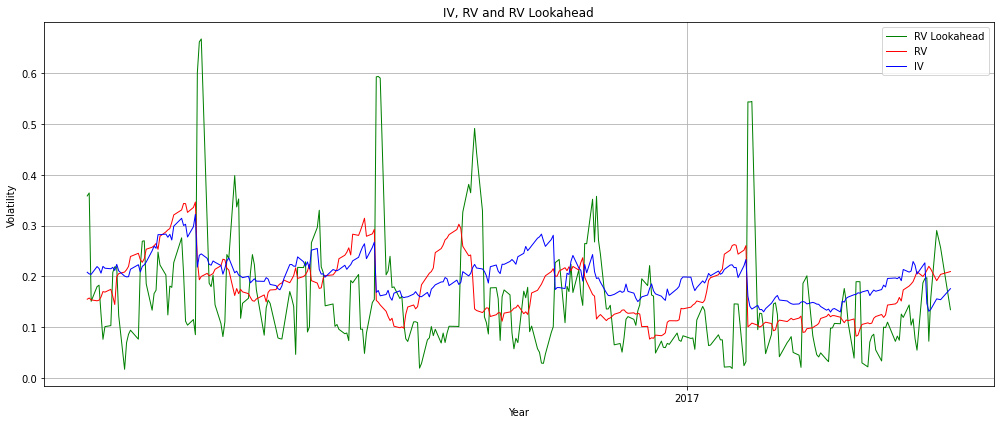

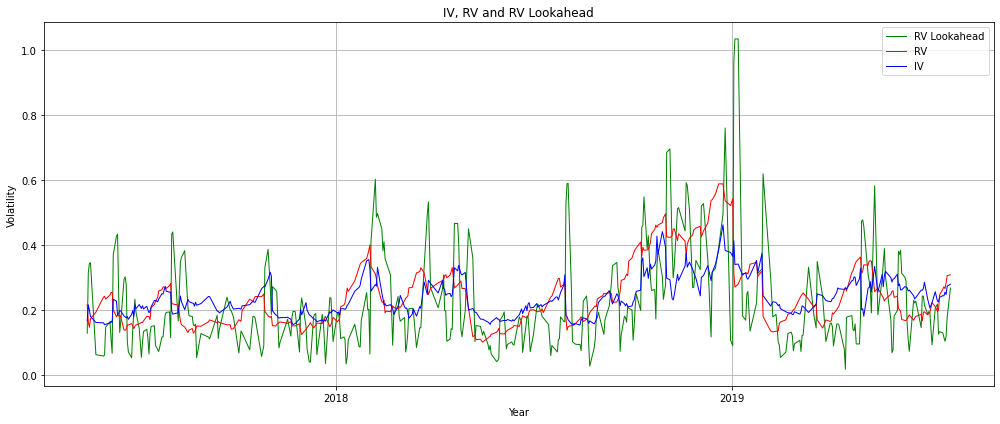

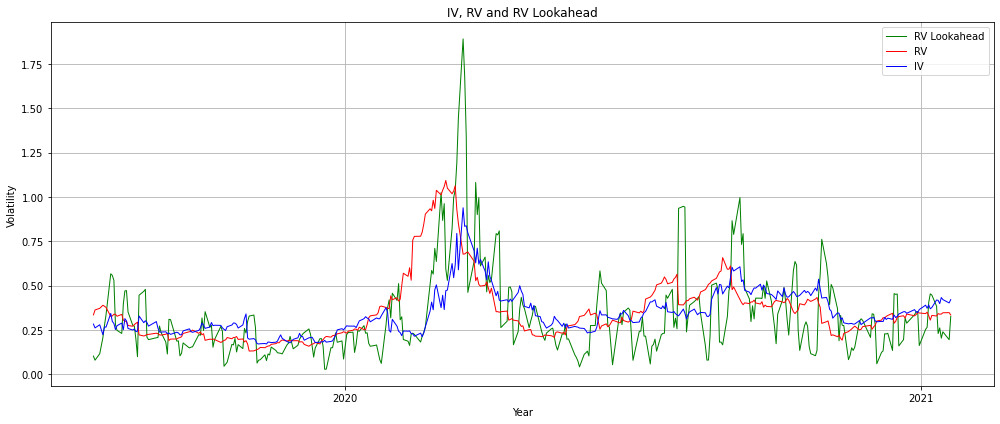

In [94]:
dates = pd.to_datetime(dates)

plt.figure(figsize=(14,6))
plt.plot(dates[:300], rv_lookahead[:300], label='RV Lookahead', color='green', linewidth=1)
plt.plot(dates[:300], rv[:300], label='RV', color='red', linewidth=1)
plt.plot(dates[:300], iv[:300], label='IV', color='blue', linewidth=1)
plt.xlabel('Year')
plt.ylabel('Volatility')
plt.title('IV, RV and RV Lookahead')
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())            
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))    
plt.tight_layout()
plt.show()


plt.figure(figsize=(14,6))
plt.plot(dates[300:700], rv_lookahead[300:700], label='RV Lookahead', color='green', linewidth=1)
plt.plot(dates[300:700], rv[300:700], label='RV', color='red', linewidth=1)
plt.plot(dates[300:700], iv[300:700], label='IV', color='blue', linewidth=1)
plt.xlabel('Year')
plt.ylabel('Volatility')
plt.title('IV, RV and RV Lookahead')
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())         
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))    
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,6))
plt.plot(dates[700:], rv_lookahead[700:], label='RV Lookahead', color='green', linewidth=1)
plt.plot(dates[700:], rv[700:], label='RV', color='red', linewidth=1)
plt.plot(dates[700:], iv[700:], label='IV', color='blue', linewidth=1)
plt.xlabel('Year')
plt.ylabel('Volatility')
plt.title('IV, RV and RV Lookahead')
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())         
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))    
plt.tight_layout()
plt.show()


### Displaying only the graph of IV vs RV averaged across the term structure : 

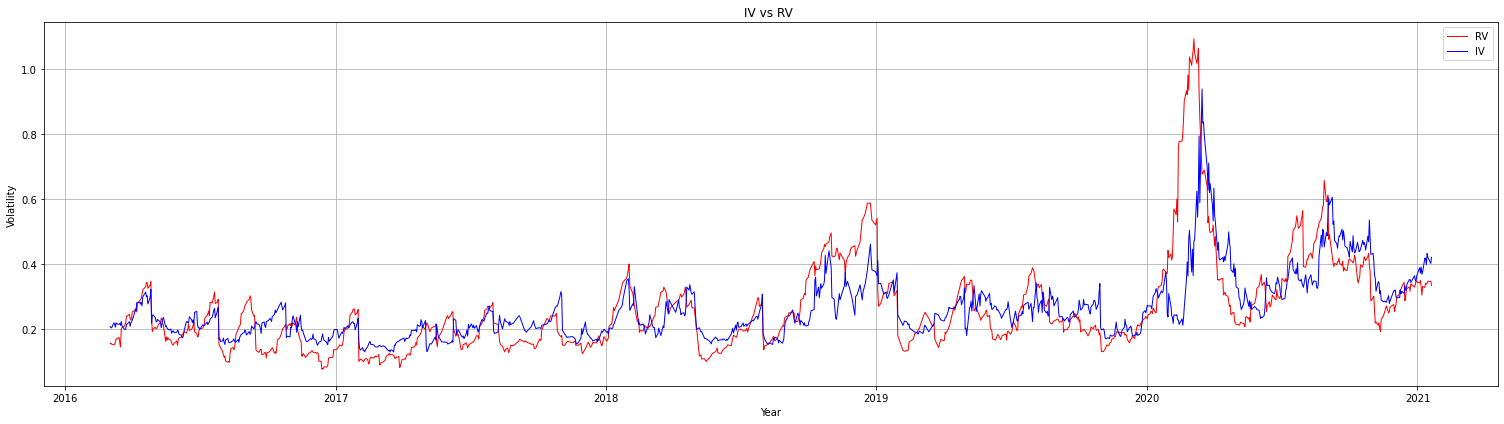

In [95]:
dates = pd.to_datetime(dates)

plt.figure(figsize=(21,6))
plt.plot(dates, rv, label='RV', color='red', linewidth=1)
plt.plot(dates, iv, label='IV', color='blue', linewidth=1)
plt.xlabel('Year')
plt.ylabel('Volatility')
plt.title('IV vs RV ')
plt.legend()
plt.grid(True)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())          
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))    

plt.tight_layout()
plt.show()

In [102]:
df_filtered_price_train = df_train[['Date','Price']].drop_duplicates().copy()
df_filtered_price_train = df_filtered_price_train[df_filtered_price_train['Date'] > " 2016-03-01"]

rolling_window1 = 10
rolling_window2 = 1

rv_lookahead10 = []
rv_lookahead2 = [] 

for _,row in df_filtered_price_train.iterrows():
    id_date = df_price['Date'].tolist().index(row['Date'])

    list_pric_10 = df_price['Price'].iloc[id_date-rolling_window1:id_date+1]
    list_pric_2 = df_price['Price'].iloc[id_date-rolling_window2:id_date+1]

    logr10 = np.diff(np.log(list_pric_10))
    vol10 = np.sqrt(np.mean(logr10 ** 2) * 252)
    rv_lookahead10.append(vol10)

    logr2 = np.diff(np.log(list_pric_2))
    vol2 = np.sqrt(np.mean(logr2 ** 2) * 252)
    rv_lookahead2.append(vol2)

df_filtered_price_train['rv_lookahead_10d'] = rv_lookahead10
df_filtered_price_train['rv_lookahead_2d'] = rv_lookahead2


### Let's try the following strat :
- **If vol2d > threshold_h * vol10d : short**
- **If vol2d < threshold_l * vol10d : long**

Let's compute the best couple of threshold (threshold_h,threshold_l) which maximise the performance in df_train

In [103]:
dic_vol10 = dict(zip(df_filtered_price_train['Date'],df_filtered_price_train['rv_lookahead_10d']))
dic_vol2 = dict(zip(df_filtered_price_train['Date'],df_filtered_price_train['rv_lookahead_2d']))

df_filtered_strad = df_train[df_train['Date'] > " 2016-03-01"].copy()

threshold_h_range = np.arange(1.1, 4.0, 0.1)
threshold_l_range = np.arange(0.1, 1.0, 0.05)

dates = df_filtered_strad['Date'].values
iv = df_filtered_strad['IV'].values
rv = df_filtered_strad['vol_real'].values
vol2 = np.array([dic_vol2[d] for d in dates])
vol10 = np.array([dic_vol10[d] for d in dates])

# Calibration LONG 
best_rate_h, best_h, nb_trade_h = 0, None, 0
for h in threshold_h_range:
    cond_long = vol2 > h * vol10
    if cond_long.any():
        valid_long = (rv > iv) & cond_long
        rate = valid_long.sum() / cond_long.sum()
        #print(f"[LONG] h:{h:.2f}, success rate = {rate*100:.2f}%, nbtrade = {cond_long.sum()}")
        if rate > best_rate_h:
            best_rate_h, best_h, nb_trade_h = rate, h, cond_long.sum()

# Calibration SHORT
best_rate_l, best_l, nb_trade_l = 0, None, 0
for l in threshold_l_range:
    cond_short = vol2 < l * vol10
    if cond_short.any():
        valid_short = (rv < iv) & cond_short
        rate = valid_short.sum() / cond_short.sum()
        #print(f"[SHORT] l:{l:.2f}, success rate = {rate*100:.2f}%, nbtrade = {cond_short.sum()}")
        if rate > best_rate_l:
            best_rate_l, best_l, nb_trade_l = rate, l, cond_short.sum()

print(f"\nBest LONG threshold_h = {best_h}, success rate = {best_rate_h*100:.2f}% on nb_trade = {nb_trade_h}")
print(f"Best SHORT threshold_l = {best_l}, success rate = {best_rate_l*100:.2f}% on nb_trade = {nb_trade_l}")


Best LONG threshold_h = 2.5000000000000013, success rate = 60.68% on nb_trade = 117
Best SHORT threshold_l = 0.20000000000000004, success rate = 63.74% on nb_trade = 1092


The best threshold is **threshold_h = 2.5 and threshold_l = 0.2** with a success rate of **60.68%** on 117 long trades and **63.74%** on 1092 short trades

In [104]:
threshold_h = 2.5
threshold_l = 0.2

trade_valid = []
df_filtered_strad = df_train[df_train['Date'] > " 2016-03-01"].copy()
for _, row in df_filtered_strad.iterrows():
    #print(f"vol2:{dic_vol2[row['Date']]}, vol10:{dic_vol10[row['Date']]}")
    if dic_vol2[row['Date']] > threshold_h * dic_vol10[row['Date']]:  # LONG
        trade_valid.append(row['vol_real'] > row['IV'])
    elif dic_vol2[row['Date']] < threshold_l * dic_vol10[row['Date']]:  # SHORT
        trade_valid.append(row['vol_real'] < row['IV'] )

print(f"The strategy achieved a success rate of {np.mean(trade_valid):.2%} on {len(trade_valid)} straddle trades in df_train.")

The strategy achieved a success rate of 63.44% on 1209 straddle trades in df_train.


**Let's now test this strat on df_validation with the threshold we calibrated on df_train**

In [105]:
df_filtered_price_validation = df_validation[['Date','Price']].drop_duplicates().copy()

rolling_window1 = 10
rolling_window2 = 1

rv_lookahead10 = []
rv_lookahead2 = [] 

for _,row in df_filtered_price_validation.iterrows():
    id_date = df_price['Date'].tolist().index(row['Date'])

    list_pric_10 = df_price['Price'].iloc[id_date-rolling_window1:id_date+1]
    list_pric_2 = df_price['Price'].iloc[id_date-rolling_window2:id_date+1]

    logr10 = np.diff(np.log(list_pric_10))
    vol10 = np.sqrt(np.mean(logr10 ** 2) * 252)
    rv_lookahead10.append(vol10)

    logr2 = np.diff(np.log(list_pric_2))
    vol2 = np.sqrt(np.mean(logr2 ** 2) * 252)
    rv_lookahead2.append(vol2)


df_filtered_price_validation['rv_lookahead_10d'] = rv_lookahead10
df_filtered_price_validation['rv_lookahead_2d'] = rv_lookahead2

dic_vol10 = dict(zip(df_filtered_price_validation['Date'],df_filtered_price_validation['rv_lookahead_10d']))
dic_vol2 = dict(zip(df_filtered_price_validation['Date'],df_filtered_price_validation['rv_lookahead_2d']))

threshold_h = 2.5
threshold_l = 0.2
trade_valid = []
df_filtered_strad = df_validation.copy()
for _, row in df_filtered_strad.iterrows():
    if dic_vol2[row['Date']] > threshold_h * dic_vol10[row['Date']]:  # LONG
        trade_valid.append(row['vol_real'] > row['IV'] )
    elif dic_vol2[row['Date']] < threshold_l * dic_vol10[row['Date']]:  # SHORT
        trade_valid.append(row['vol_real'] < row['IV'])

print(f"The strategy achieved a success rate of {np.mean(trade_valid):.2%} on {len(trade_valid)} straddle trades in df_train.")

The strategy achieved a success rate of 61.64% on 232 straddle trades in df_train.
